In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import sys

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/0415_data_4.csv", sep=",", header=None)
X1 = train.values[0:, 0:9]
X2 = train.values[0:, 12:17]
X = np.concatenate((X1,X2), axis=1)
y = train.values[0:, 18:]

X = X.astype('float64') 
y = y.astype('float64') 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).squeeze(1).long() - 1
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).squeeze(1).long() - 1

BATCH_SIZE = 10

training_dataset = TensorDataset(X_train, y_train)
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testing_dataset = TensorDataset(X_test, y_test)
testing_dataloader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=False)


Training data shape:  (246, 14)
Training labels shape:  (246, 1)
Test data shape:  (62, 14)
Test labels shape:  (62, 1)


In [ ]:
class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    
  def forward(self, x):
    h = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h)
    y_pred = torch.nn.functional.softmax(y_pred, dim=1)
    return y_pred

In [ ]:
# D_in, H, D_out = 14, 100, 4
# k = 0

# model = TwoLayerNet(D_in, H, D_out).double()

# init_w = model.state_dict()

# print(init_w['linear1.weight'])

# temp_w = init_w.copy()
# temp_w['linear1.weight'][k].zero_()

# print(temp_w['linear1.weight'])

# model.load_state_dict(temp_w)

# new_w = model.state_dict()
# print(new_w['linear1.weight'])

In [ ]:
D_in, H, D_out = 14, 100, 4
GIVEN_E = 1
GIVEN_lr = 1e-6
EPOCH = 100

p = H
k = 0

model = TwoLayerNet(D_in, H, D_out).double()

optimizer_reg = torch.optim.RMSprop(model.parameters(),lr=1e-3)
optimizer_match = torch.optim.Adam(model.parameters(),lr=1e-4)

train_loss_list = []
train_acc_list = []

while k < p:
  
  train_loss = 0
  train_correct = 0
  
  optimizer_reg.zero_grad()

  # for x,y in (training_dataloader):
    
  #   y_pred = model(x)        
  #   loss = torch.nn.functional.cross_entropy(y_pred, y)

  #   train_loss += loss

  #   # _, y_pred = torch.max(y_pred,1)
           
  #   # train_correct += (y_pred==y).sum()
  #   # train_correct = int(train_correct)

  if k > p:
    break
  else:
    ## regularizing model
    t = 0
    print('---regularizing model---')
    while t < EPOCH:

      hold = False
      train_loss = 0
      train_correct = 0
      
      lr = optimizer_reg.param_groups[0]['lr']
      init_weight = model.state_dict()

      optimizer_reg.zero_grad()

      for x,y in (training_dataloader):
        
        y_pred = model(x)        
        loss = torch.nn.functional.cross_entropy(y_pred, y)

        train_loss += loss

        _, y_pred = torch.max(y_pred,1)
              
        train_correct += (y_pred==y).sum()
        train_correct = int(train_correct)

      train_loss.backward()
      optimizer_reg.step()

      # CALCULATE LOSS WITH MODEL AGAIN

      new_loss = 0

      for x, y in training_dataloader:
        new_loss += torch.nn.functional.cross_entropy(model(x), y)

      if new_loss <= train_loss: ## train_loss嗎?
        if new_loss/len(training_dataloader) <= GIVEN_E:
          optimizer_reg.lr = lr * 1.2
        else:
          model.load_state_dict(init_weight)
      else:
        if lr > GIVEN_lr:
          model.load_state_dict(init_weight)
          optimizer_reg.lr = lr * 0.7
          hold = True
        else:
          model.load_state_dict(init_weight)

      if not hold:
        train_loss =  train_loss / len(training_dataloader)
        new_loss = new_loss / len(training_dataloader)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_correct / len(training_dataset))
        if t % 10 == 0:
          print(f'Epoch: {t}, Train loss: ', train_loss.item(), ',New Loss:', new_loss.item(), ',acc:', train_acc_list[-1])
        t += 1
      else:
        pass
    
    
    now_weight = model.state_dict()

    ### 把第k個node的weight設成0
    temp_weight = now_weight.copy()
    temp_weight['linear1.weight'][k].zero_()

    model.load_state_dict(temp_weight)

    ## matching module

    print('---matching model---')
    optimizer_match.zero_grad()
    
    for i in range(100):

      match_train_loss = 0
      match_train_correct = 0
      
      for x,y in (training_dataloader):    
        y_pred = model(x)
        match_train_loss += torch.nn.functional.cross_entropy(y_pred, y)

        _, y_pred = torch.max(y_pred,1)
              
        match_train_correct += (y_pred==y).sum()
        match_train_correct = int(match_train_correct)
      
      if match_train_loss/len(training_dataloader) <= GIVEN_E:
        model.load_state_dict(temp_weight)
        p -= 1
        break
      else:
        match_train_loss.backward()
        optimizer_match.step()
        if i==99:
          model.load_state_dict(now_weight)
          k += 1
      
      match_train_loss =  match_train_loss / len(training_dataloader)
      train_loss_list.append(match_train_loss)
      train_acc_list.append(match_train_correct / len(training_dataset))
      
      if i % 10 == 0:
        print(f'i={i}, Train loss: ', match_train_loss.item(), 'acc:', train_acc_list[-1])
      
      if len(train_loss_list) > 1500:
        sys.exit()


---regularizing model---
Epoch: 0, Train loss:  1.4383560444351513 ,New Loss: 1.3414494183428582 ,acc: 0.16260162601626016
Epoch: 10, Train loss:  1.254000716413104 ,New Loss: 1.248182299904704 ,acc: 0.5040650406504065
Epoch: 20, Train loss:  1.212625838091358 ,New Loss: 1.2114907673671316 ,acc: 0.5772357723577236
Epoch: 30, Train loss:  1.1969439003018139 ,New Loss: 1.1908886855299665 ,acc: 0.5894308943089431
Epoch: 40, Train loss:  1.1789374669900428 ,New Loss: 1.17627513870577 ,acc: 0.6016260162601627
Epoch: 50, Train loss:  1.1645192467981396 ,New Loss: 1.1636514627191437 ,acc: 0.6016260162601627
Epoch: 60, Train loss:  1.1605427883797306 ,New Loss: 1.1577686553013822 ,acc: 0.6097560975609756
Epoch: 70, Train loss:  1.1515470236446392 ,New Loss: 1.1491813264156492 ,acc: 0.6097560975609756
Epoch: 80, Train loss:  1.1417156658648102 ,New Loss: 1.1381398190328118 ,acc: 0.6219512195121951
Epoch: 90, Train loss:  1.143133842296639 ,New Loss: 1.1409605582701101 ,acc: 0.6219512195121951
-

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


100


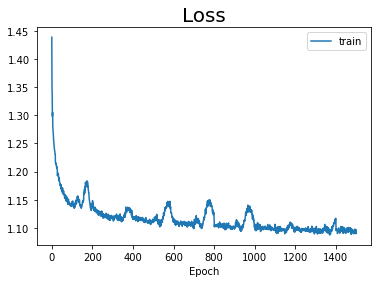

In [ ]:
plt.plot(train_loss_list, label='train')
plt.xlabel('Epoch')
plt.title('Loss',size = 20)
plt.legend()
plt.show()

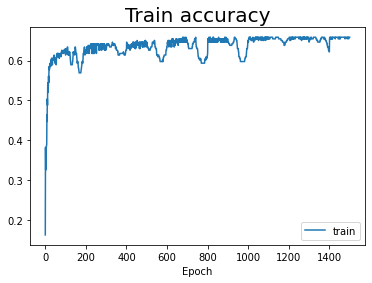

In [ ]:
plt.plot(train_acc_list, label='train')
plt.legend()
plt.xlabel('Epoch')
plt.title('Train accuracy',size = 20)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  test_loss = 0 # accumulate testing loss for each batch
  test_correct = 0

  for x, y in testing_dataloader:

    prediction = model(x) # call forward function
        
    loss = torch.nn.functional.cross_entropy(prediction, y)
    test_loss += loss

    _, prediction = torch.max(prediction,1)
        
    test_correct += (prediction==y).sum()
    test_correct = int(test_correct)

  test_loss = test_loss.item()

print("Test loss:{:.2f}, Test accuracy: {:.2f}".format(test_loss / len(testing_dataloader),test_correct / len(testing_dataset)))

Test loss:1.14, Test accuracy: 0.61
